In [1]:
%pip install matplotlib
%pip install tensorflow
%pip install scipy
%pip install opencv-python
%pip install scikit-learn
%pip install seaborn



import matplotlib.pyplot as plt
import scipy
import os
import cv2
import numpy as np
import tensorflow as tf
import seaborn as sns

from PIL import Image
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from random import randint # from kaggle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.



In [2]:
# Define the paths to your train and test data
train_data_dir = 'dataset/train'
test_data_dir = 'dataset/test'

In [3]:
# Set up ImageDataGenerators for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,        # Normalize pixel values to the range [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,       # Randomly apply shear transformations
    zoom_range=0.2,        # Randomly zoom into images
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'
)

In [4]:
# Set up ImageDataGenerator for testing data
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# Set batch size
batch_size = 32

In [6]:
# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(128, 128),  # (224,224)-is a common size for images in CNNs. Can adjust based on the model's input size, so it changed tp (128,128)
    batch_size=32,
    class_mode='categorical'  # categorical use for multi-class classification, we have 19 classes. So let's go with categorical. Use 'binary' for binary classification
)

Found 2609 images belonging to 19 classes.


In [7]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 896 images belonging to 19 classes.


In [8]:
path = 'dataset/train'

In [9]:
class_names = sorted(os.listdir(path))
num_classes = len(class_names)

img_size = (192, 192, 3)

print('classes: ', class_names)

classes:  ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']


In [10]:
labels = []
images = []

print('images:\n')
for cl in class_names:
    print(cl, end=' -> ')

     # Construct the full path for the current class
    class_path = os.path.join(path, cl)
    
    # Check if the path is a directory
    if os.path.isdir(class_path):
        for img in os.listdir(class_path):
            label = np.zeros(num_classes)
            label[class_names.index(cl)] = 1
            labels.append(label)
        
            image_path = os.path.join(class_path, img)
            image = np.asarray(cv2.resize(cv2.imread(image_path, cv2.IMREAD_COLOR), img_size[0:2])[:, :, ::-1])  # This line removes Blue
            images.append(image)
        print('done')

labels = np.asarray(labels)
images = np.asarray(images)

print(f'\n\nlabels shape: {labels.shape}')
print(f'images shape: {images.shape}')

images:

Acne and Rosacea Photos -> done
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions -> done
Atopic Dermatitis Photos -> done
Cellulitis Impetigo and other Bacterial Infections -> done
Eczema Photos -> done
Exanthems and Drug Eruptions -> done
Herpes HPV and other STDs Photos -> done
Light Diseases and Disorders of Pigmentation -> done
Lupus and other Connective Tissue diseases -> done
Melanoma Skin Cancer Nevi and Moles -> done
Poison Ivy Photos and other Contact Dermatitis -> done
Psoriasis pictures Lichen Planus and related diseases -> done
Seborrheic Keratoses and other Benign Tumors -> done
Systemic Disease -> done
Tinea Ringworm Candidiasis and other Fungal Infections -> done
Urticaria Hives -> done
Vascular Tumors -> done
Vasculitis Photos -> done
Warts Molluscum and other Viral Infections -> done


labels shape: (2609, 19)
images shape: (2609, 192, 192, 3)


In [11]:
# Load ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False)

In [12]:
# Add custom layers for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(19, activation='softmax')(x)


In [13]:
# Create a new model
skin_disease_model = Model(inputs=base_model.input, outputs=predictions)


In [14]:
# Freeze the weights of the pre-trained ResNet50 layers
for layer in base_model.layers:
    layer.trainable = False

In [15]:
# Compile the model
skin_disease_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Adjust the number of epochs based on your dataset and computational resources
epochs = 10

Epochs from kaggle code

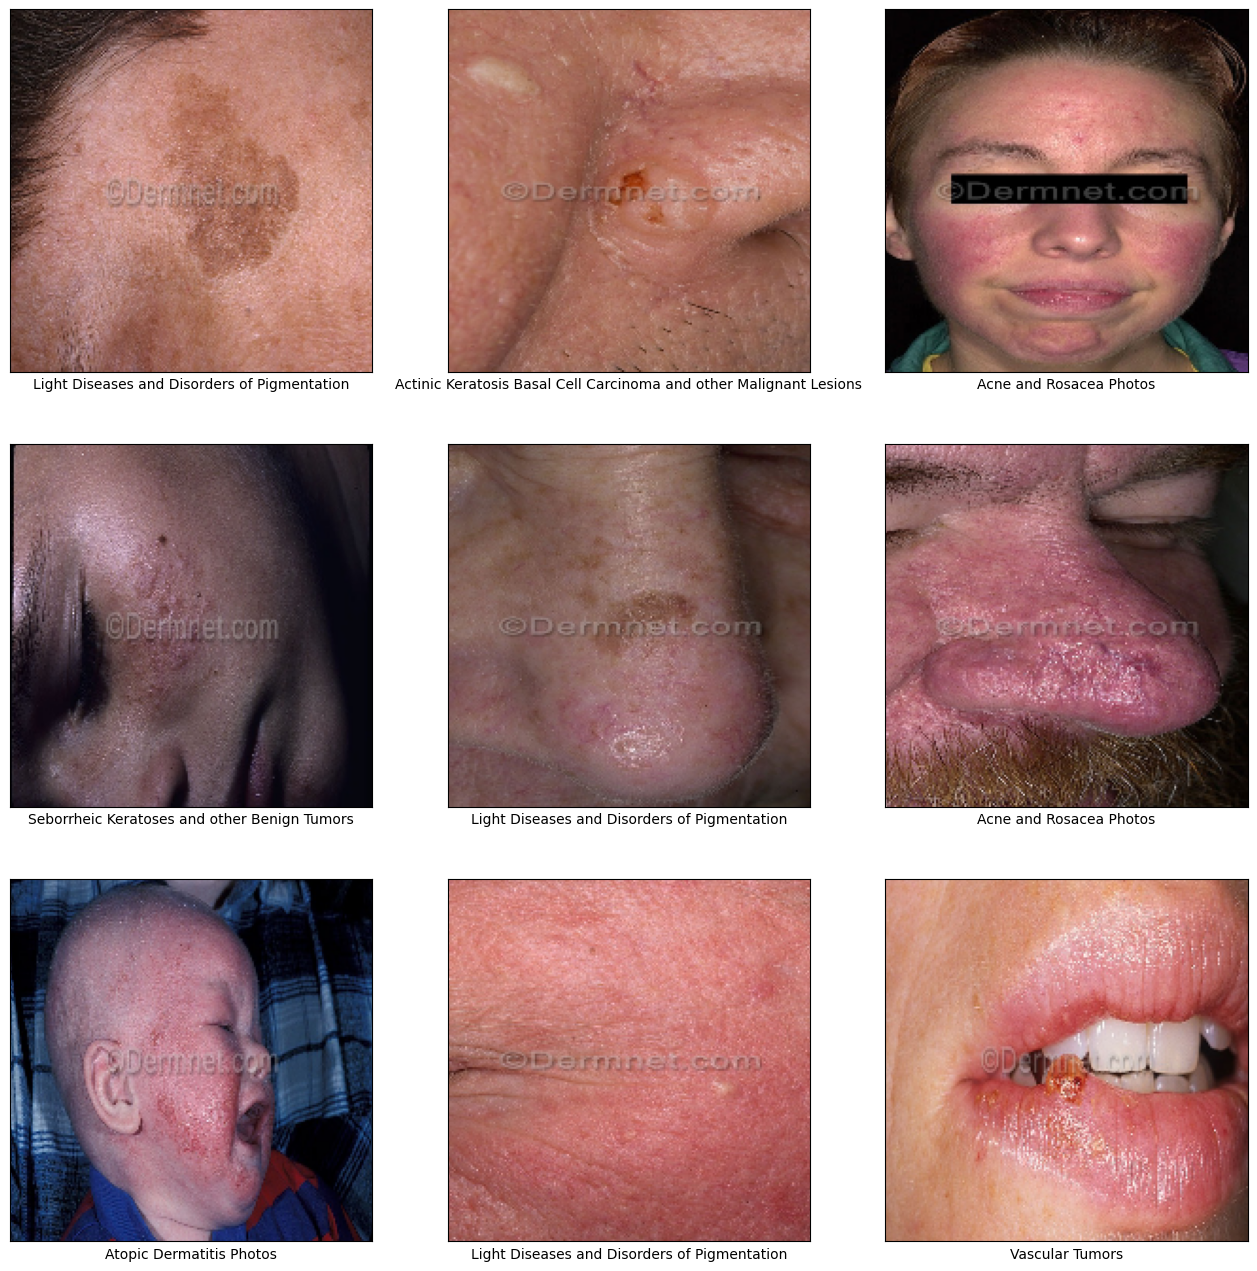

In [17]:
# Create a 3x3 grid of subplots with a specified figure size
fig, axs = plt.subplots(3, 3, figsize=(16, 16))#Original was 10,6

# Loop through the subplots
for x in range(3):
    for y in range(3):
        # Generate a random index to select a random image
        i = randint(0, len(images))
        
        # Display the image in the current subplot
        axs[x][y].imshow(images[i])
        
                    
        # Set ticks and labels to remove axis values
        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        
        # Set the xlabel to the corresponding class name
        axs[x][y].set_xlabel(class_names[np.argmax(labels[i])])
        
        
# Show the plot
plt.show()

In [18]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.15, random_state=42)

print(f'train images shape: {X_train.shape}\ntrain labels shape: {y_train.shape}\n\nvalidation images shape: {X_val.shape}\nvalidation labels shape: {y_val.shape}\n')

train images shape: (2217, 192, 192, 3)
train labels shape: (2217, 19)

validation images shape: (392, 192, 192, 3)
validation labels shape: (392, 19)



In [19]:
#import tensorflow as tf #added to the top

cnn_model = tf.keras.Sequential()

# Inputs and rescaling
cnn_model.add(tf.keras.layers.Rescaling(scale=1. / 255, input_shape=(img_size)))

# Convolutional block 1
cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

# Convolutional block 2
cnn_model.add(tf.keras.layers.Conv2D(128, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.Conv2D(128, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

# Convolutional block 3
cnn_model.add(tf.keras.layers.Conv2D(256, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.Conv2D(256, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

# Convolutional block 4
cnn_model.add(tf.keras.layers.Conv2D(512, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.Conv2D(512, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
cnn_model.add(tf.keras.layers.Flatten())

# Dense block
cnn_model.add(tf.keras.layers.Dense(256, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(128, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(64, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))


cnn_model.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 192, 192, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 192, 192, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 96, 96, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 128)       32896     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 128)       65664     
                                                        

In [20]:
# creating ModelChecpoint callback
checkpoint_callback = ModelCheckpoint('cnn_model/model{epoch:02d}')

In [21]:
history = cnn_model.fit(images, labels, epochs=20, validation_data=(X_val, y_val), callbacks=[checkpoint_callback])

Epoch 1/20


82/82 [==============================] - ETA: 0s - loss: 2.5436 - accuracy: 0.2737 INFO:tensorflow:Assets written to: cnn_model\model01\assets


INFO:tensorflow:Assets written to: cnn_model\model01\assets


82/82 [==============================] - 925s 11s/step - loss: 2.5436 - accuracy: 0.2737 - val_loss: 2.3817 - val_accuracy: 0.3265
Epoch 2/20
82/82 [==============================] - ETA: 0s - loss: 2.3516 - accuracy: 0.3220 INFO:tensorflow:Assets written to: cnn_model\model02\assets


INFO:tensorflow:Assets written to: cnn_model\model02\assets


82/82 [==============================] - 905s 11s/step - loss: 2.3516 - accuracy: 0.3220 - val_loss: 2.3494 - val_accuracy: 0.3291
Epoch 3/20
82/82 [==============================] - ETA: 0s - loss: 2.3007 - accuracy: 0.3239 INFO:tensorflow:Assets written to: cnn_model\model03\assets


INFO:tensorflow:Assets written to: cnn_model\model03\assets


82/82 [==============================] - 899s 11s/step - loss: 2.3007 - accuracy: 0.3239 - val_loss: 2.2872 - val_accuracy: 0.3138
Epoch 4/20
82/82 [==============================] - ETA: 0s - loss: 2.2294 - accuracy: 0.3327 INFO:tensorflow:Assets written to: cnn_model\model04\assets


INFO:tensorflow:Assets written to: cnn_model\model04\assets


82/82 [==============================] - 898s 11s/step - loss: 2.2294 - accuracy: 0.3327 - val_loss: 2.2104 - val_accuracy: 0.3469
Epoch 5/20
82/82 [==============================] - ETA: 0s - loss: 2.1853 - accuracy: 0.3503 INFO:tensorflow:Assets written to: cnn_model\model05\assets


INFO:tensorflow:Assets written to: cnn_model\model05\assets


82/82 [==============================] - 913s 11s/step - loss: 2.1853 - accuracy: 0.3503 - val_loss: 2.1686 - val_accuracy: 0.3546
Epoch 6/20
82/82 [==============================] - ETA: 0s - loss: 2.1290 - accuracy: 0.3653 INFO:tensorflow:Assets written to: cnn_model\model06\assets


INFO:tensorflow:Assets written to: cnn_model\model06\assets


82/82 [==============================] - 911s 11s/step - loss: 2.1290 - accuracy: 0.3653 - val_loss: 2.0534 - val_accuracy: 0.3622
Epoch 7/20
82/82 [==============================] - ETA: 0s - loss: 2.0119 - accuracy: 0.3990 INFO:tensorflow:Assets written to: cnn_model\model07\assets


INFO:tensorflow:Assets written to: cnn_model\model07\assets


82/82 [==============================] - 917s 11s/step - loss: 2.0119 - accuracy: 0.3990 - val_loss: 1.8893 - val_accuracy: 0.4541
Epoch 8/20
82/82 [==============================] - ETA: 0s - loss: 1.8060 - accuracy: 0.4527 INFO:tensorflow:Assets written to: cnn_model\model08\assets


INFO:tensorflow:Assets written to: cnn_model\model08\assets


82/82 [==============================] - 913s 11s/step - loss: 1.8060 - accuracy: 0.4527 - val_loss: 1.5548 - val_accuracy: 0.5434
Epoch 9/20
82/82 [==============================] - ETA: 0s - loss: 1.5523 - accuracy: 0.5358 INFO:tensorflow:Assets written to: cnn_model\model09\assets


INFO:tensorflow:Assets written to: cnn_model\model09\assets


82/82 [==============================] - 902s 11s/step - loss: 1.5523 - accuracy: 0.5358 - val_loss: 1.2030 - val_accuracy: 0.6301
Epoch 10/20
82/82 [==============================] - ETA: 0s - loss: 1.1945 - accuracy: 0.6363 INFO:tensorflow:Assets written to: cnn_model\model10\assets


INFO:tensorflow:Assets written to: cnn_model\model10\assets


82/82 [==============================] - 889s 11s/step - loss: 1.1945 - accuracy: 0.6363 - val_loss: 0.8327 - val_accuracy: 0.7449
Epoch 11/20
82/82 [==============================] - ETA: 0s - loss: 0.8232 - accuracy: 0.7532 INFO:tensorflow:Assets written to: cnn_model\model11\assets


INFO:tensorflow:Assets written to: cnn_model\model11\assets


82/82 [==============================] - 902s 11s/step - loss: 0.8232 - accuracy: 0.7532 - val_loss: 0.4741 - val_accuracy: 0.8673
Epoch 12/20
82/82 [==============================] - ETA: 0s - loss: 0.5492 - accuracy: 0.8379 INFO:tensorflow:Assets written to: cnn_model\model12\assets


INFO:tensorflow:Assets written to: cnn_model\model12\assets


82/82 [==============================] - 906s 11s/step - loss: 0.5492 - accuracy: 0.8379 - val_loss: 0.3740 - val_accuracy: 0.9133
Epoch 13/20
82/82 [==============================] - ETA: 0s - loss: 0.3846 - accuracy: 0.8950 INFO:tensorflow:Assets written to: cnn_model\model13\assets


INFO:tensorflow:Assets written to: cnn_model\model13\assets


82/82 [==============================] - 907s 11s/step - loss: 0.3846 - accuracy: 0.8950 - val_loss: 0.2793 - val_accuracy: 0.9439
Epoch 14/20
82/82 [==============================] - ETA: 0s - loss: 0.2724 - accuracy: 0.9302 INFO:tensorflow:Assets written to: cnn_model\model14\assets


INFO:tensorflow:Assets written to: cnn_model\model14\assets


82/82 [==============================] - 899s 11s/step - loss: 0.2724 - accuracy: 0.9302 - val_loss: 0.1801 - val_accuracy: 0.9490
Epoch 15/20
82/82 [==============================] - ETA: 0s - loss: 0.2297 - accuracy: 0.9448 INFO:tensorflow:Assets written to: cnn_model\model15\assets


INFO:tensorflow:Assets written to: cnn_model\model15\assets


82/82 [==============================] - 914s 11s/step - loss: 0.2297 - accuracy: 0.9448 - val_loss: 0.1941 - val_accuracy: 0.9541
Epoch 16/20
82/82 [==============================] - ETA: 0s - loss: 0.1975 - accuracy: 0.9563 INFO:tensorflow:Assets written to: cnn_model\model16\assets


INFO:tensorflow:Assets written to: cnn_model\model16\assets


82/82 [==============================] - 902s 11s/step - loss: 0.1975 - accuracy: 0.9563 - val_loss: 0.1407 - val_accuracy: 0.9592
Epoch 17/20
82/82 [==============================] - ETA: 0s - loss: 0.1751 - accuracy: 0.9636 INFO:tensorflow:Assets written to: cnn_model\model17\assets


INFO:tensorflow:Assets written to: cnn_model\model17\assets


82/82 [==============================] - 904s 11s/step - loss: 0.1751 - accuracy: 0.9636 - val_loss: 0.1320 - val_accuracy: 0.9668
Epoch 18/20
82/82 [==============================] - ETA: 0s - loss: 0.1653 - accuracy: 0.9632 INFO:tensorflow:Assets written to: cnn_model\model18\assets


INFO:tensorflow:Assets written to: cnn_model\model18\assets


82/82 [==============================] - 897s 11s/step - loss: 0.1653 - accuracy: 0.9632 - val_loss: 0.1257 - val_accuracy: 0.9668
Epoch 19/20
82/82 [==============================] - ETA: 0s - loss: 0.1444 - accuracy: 0.9670 INFO:tensorflow:Assets written to: cnn_model\model19\assets


INFO:tensorflow:Assets written to: cnn_model\model19\assets


82/82 [==============================] - 903s 11s/step - loss: 0.1444 - accuracy: 0.9670 - val_loss: 0.1009 - val_accuracy: 0.9668
Epoch 20/20
82/82 [==============================] - ETA: 0s - loss: 0.1314 - accuracy: 0.9686 INFO:tensorflow:Assets written to: cnn_model\model20\assets


INFO:tensorflow:Assets written to: cnn_model\model20\assets


82/82 [==============================] - 940s 11s/step - loss: 0.1314 - accuracy: 0.9686 - val_loss: 0.0862 - val_accuracy: 0.9719


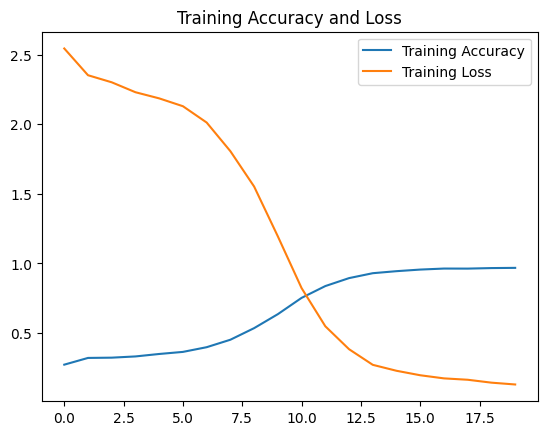

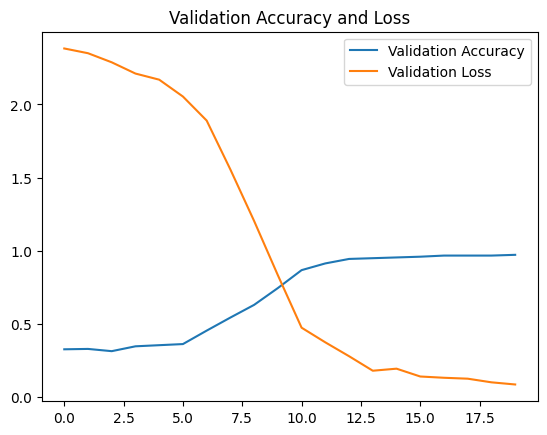

In [22]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, loss, label='Training Loss')
plt.legend()
plt.title('Training Accuracy and Loss')

plt.figure()
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.title('Validation Accuracy and Loss')

plt.show()

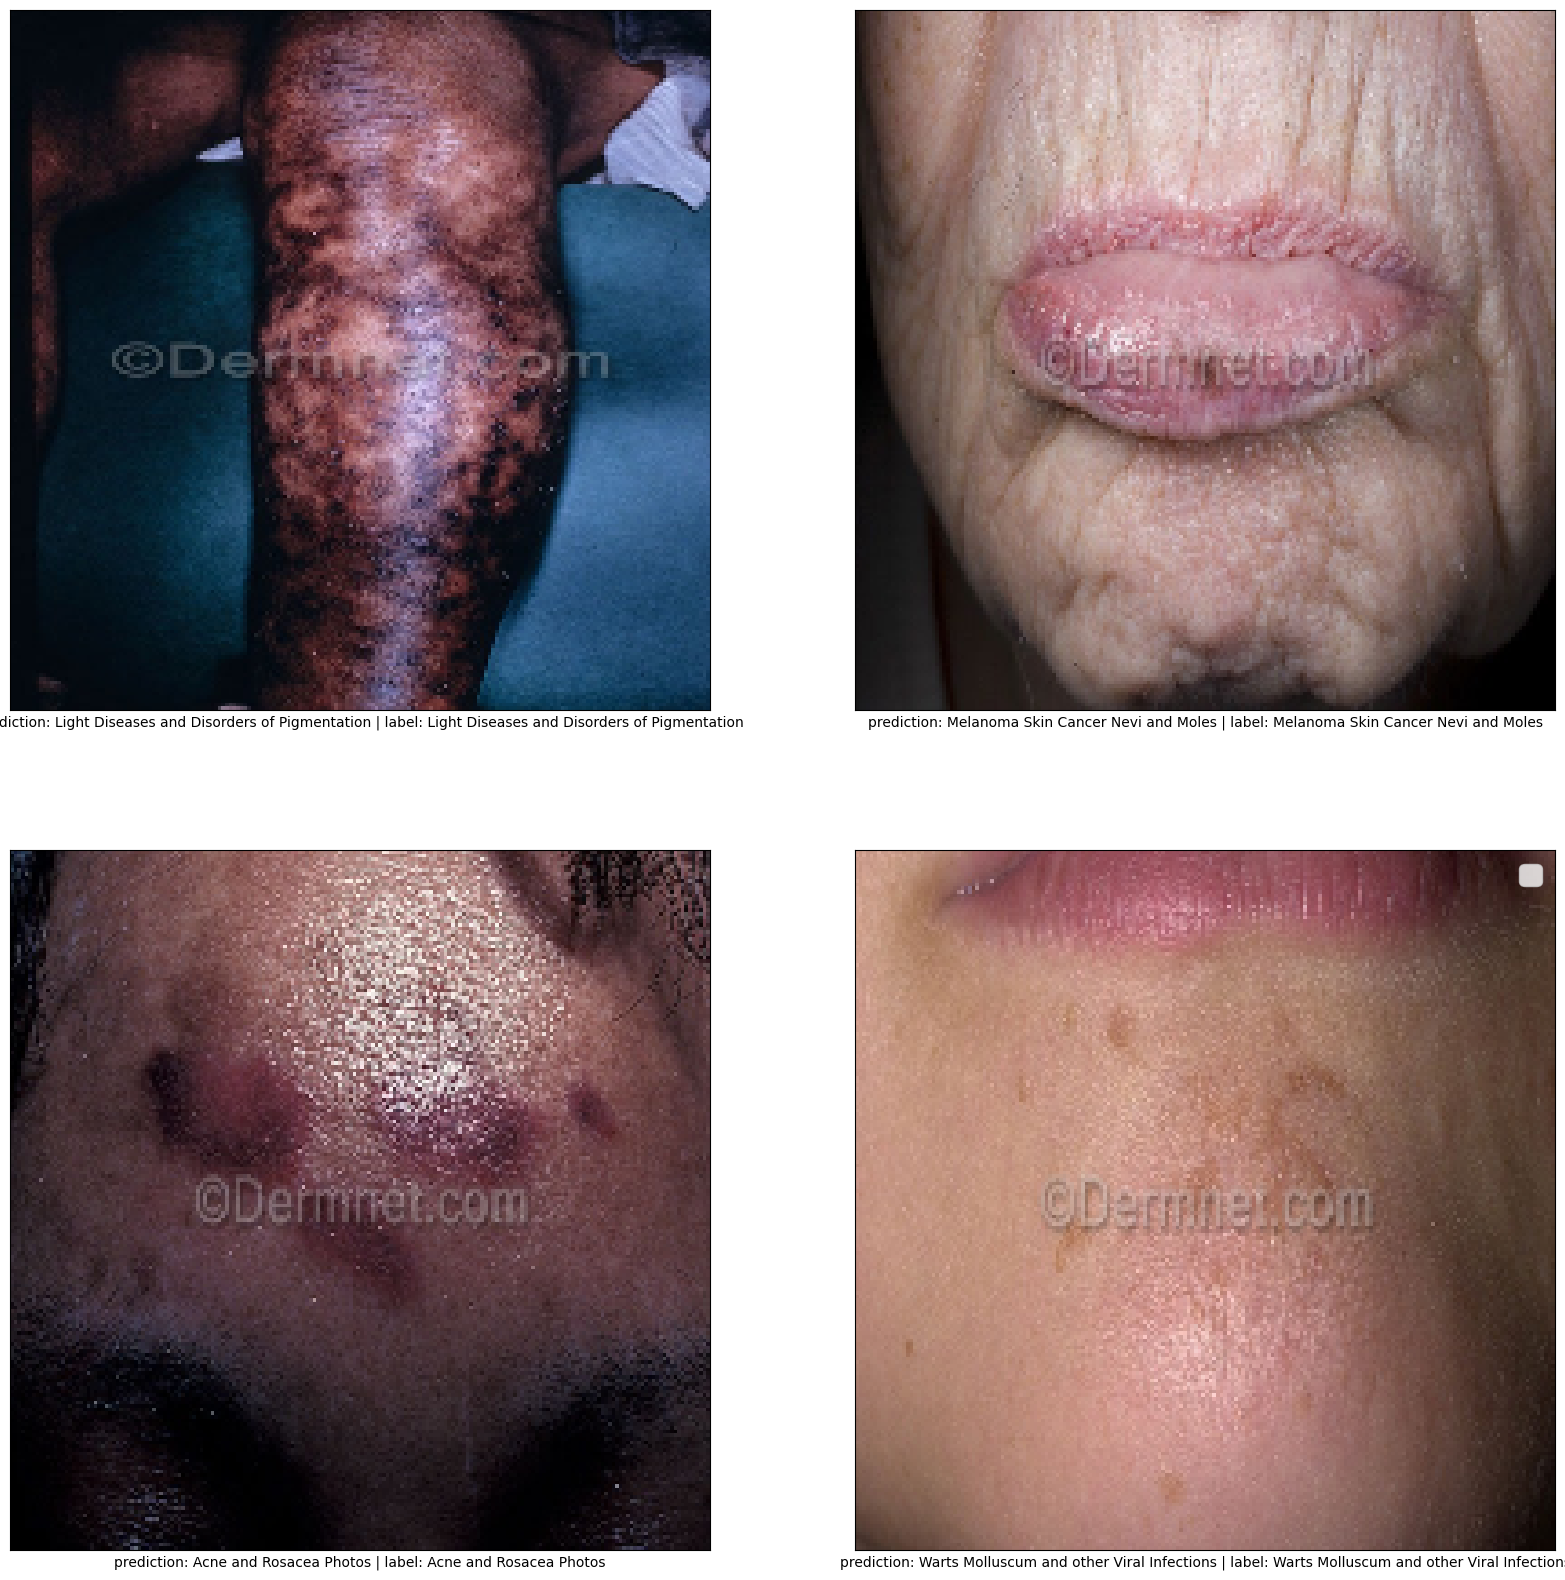

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))#Original was 7,4 (28 is higher than 25) and figsize 15,15
plt.legend(fontsize="20")#I can't read any of them

i = 0
for x in range(2): #Original was 7 so resulted in error 7X4 = 28
    for y in range(2):
        prediction = cnn_model.predict(X_val[i][None, ...], verbose=0)[0],
       
        
        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(f'prediction: {class_names[np.argmax(prediction)]} | label: {class_names[np.argmax(y_val[i])]}')
        
        axs[x][y].imshow(X_val[i])
        
        i += 1
plt.show()


In [24]:
#Exporting the model
cnn_model.save('skin_disease_ditection_model.h5')

C:\Users\Dinu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
# Convert the Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Dinu\AppData\Local\Temp\tmpspc20q_k\assets


INFO:tensorflow:Assets written to: C:\Users\Dinu\AppData\Local\Temp\tmpspc20q_k\assets


In [26]:
#preprocess individual images outside the generator

#read the image:
image_path = 'Images/eczema-acute-21.jpg'
image = cv2.imread(image_path, cv2.IMREAD_COLOR)


In [27]:
#Resize the Image:
target_size = (128, 128)
resized_image = cv2.resize(image, target_size)


In [28]:
#Data Normalization:
normalized_image = resized_image / 255.0


In [29]:
#Expand Dimensions (if needed):
expanded_image = np.expand_dims(normalized_image, axis=0)

In [30]:
def preprocess_image(image_path, target_size=(128, 128)):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Resize the image
    resized_image = cv2.resize(image, target_size)

    # Normalize pixel values
    normalized_image = resized_image / 255.0

    # Add batch dimension if needed
    expanded_image = np.expand_dims(normalized_image, axis=0)

    return expanded_image

In [31]:
#Save the model architecture in JSON format
model_json = cnn_model.to_json()

with open('model_architecture.json', 'w') as json_file:
    json_file.write(model_json)


In [32]:
#Dependencies: Provide a list of dependencies required to run the code.
#The other person will need to install these dependencies to run your code successfully.
!pip freeze > requirements.txt


In [34]:
#Create a classification report for model 

# Predictions on validation data
y_pred = cnn_model.predict(X_val)

# Convert one-hot encoded labels back to categorical labels
y_true_categorical = np.argmax(y_val, axis=1)
y_pred_categorical = np.argmax(y_pred, axis=1)

# Create a classification report
classification_report_result = classification_report(y_true_categorical, y_pred_categorical, target_names=class_names)

# Display the classification report
print("Classification Report:\n", classification_report_result)



13/13 [==============================] - 20s 1s/step
Classification Report:
                                                                     precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.94      0.99      0.97       128
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       1.00      1.00      1.00        47
                                          Atopic Dermatitis Photos       1.00      1.00      1.00        15
                Cellulitis Impetigo and other Bacterial Infections       1.00      1.00      1.00         6
                                                     Eczema Photos       1.00      1.00      1.00         5
                                      Exanthems and Drug Eruptions       1.00      1.00      1.00         5
                                  Herpes HPV and other STDs Photos       1.00      0.90      0.95        10
                      Light Diseases and Disorders of Pigm

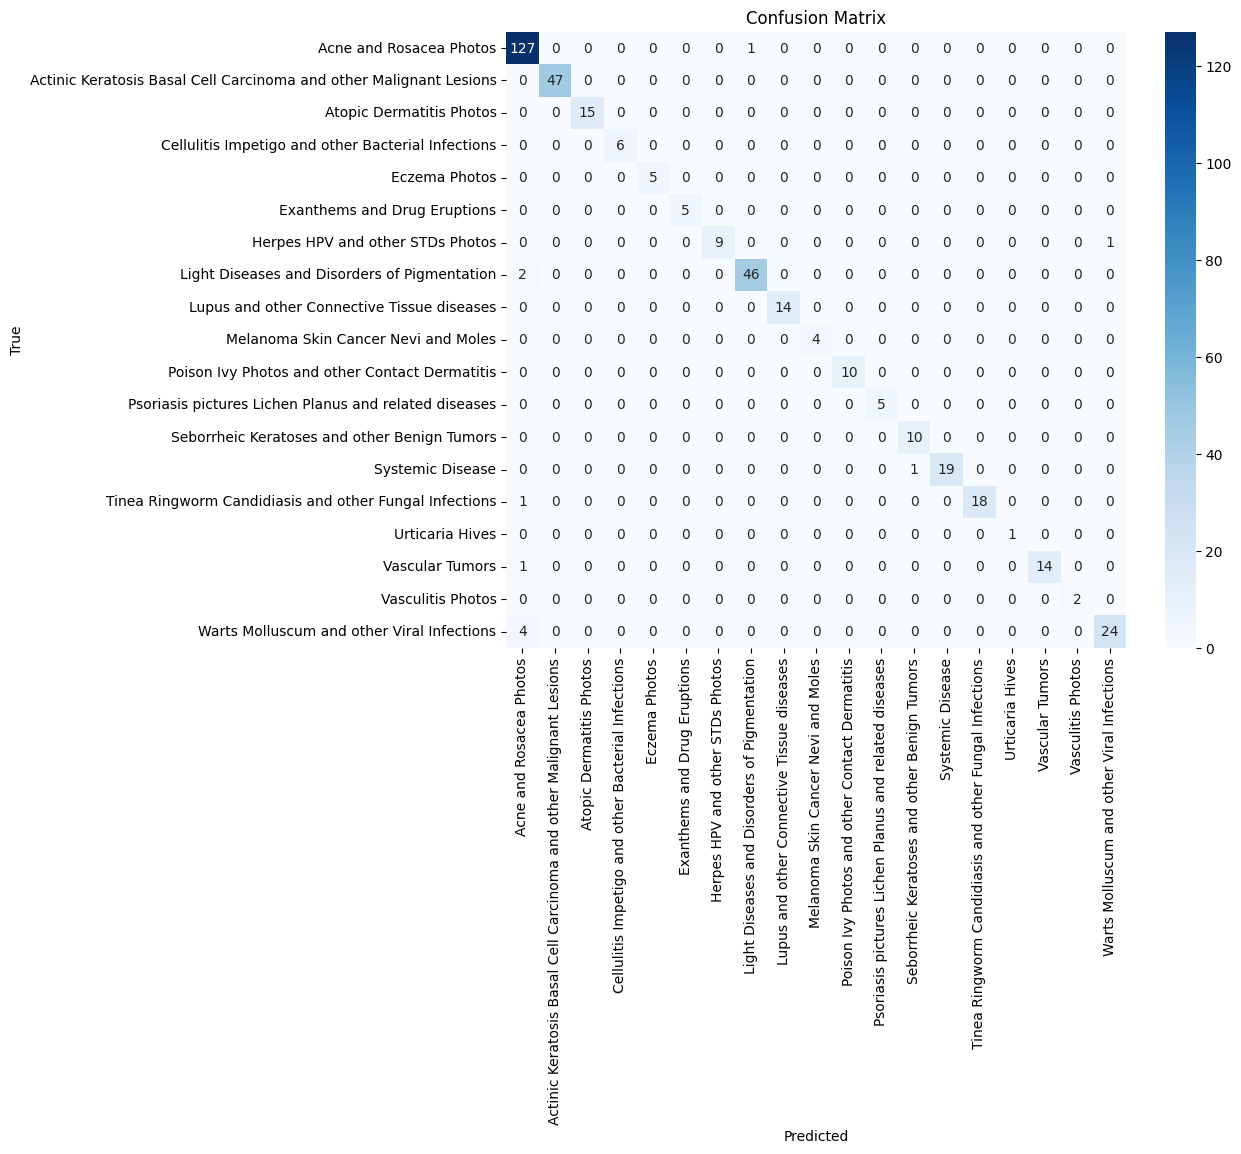

In [35]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_true_categorical, y_pred_categorical)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
